<a href="https://colab.research.google.com/github/codefinn9988/Ml_learn/blob/main/nn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Neural network from scratch using python and numpy
import numpy as np

In [2]:
class Layer_Dense:
  def __init__(self, n_inputs, n_neurons,
               weight_regularizer_l1 = 0,weight_regularizer_l2 = 0,
               bias_regularizer_l1 = 0, bias_regularizer_l2 = 0):
    self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
    self.biases = np.zeros((1, n_neurons)) # 1 is shape

    #Set regularization strength
    self.weight_regularizer_l1 = weight_regularizer_l1
    self.weight_regularizer_l2 = weight_regularizer_l2
    self.bias_regularizer_l1 = bias_regularizer_l1
    self.bias_regularizer_l2 = bias_regularizer_l2

  def forward(self, inputs):
    self.inputs = inputs
    self.output = np.dot(inputs, self.weights) + self.biases

  def backward(self,dvalues): #dvalues = gradient of loss with respect to the layer's output
    #dl/dw (gradient of weights)
    self.dweights =np.dot(self.inputs.T,dvalues)
    #dl/db (gradient of bias)
    self.dbiases = np.sum(dvalues,axis=0,keepdims=True)

    # Gradients on regularization
    # L1 on weights
    if self.weight_regularizer_l1 >0:
      dL1 = np.ones_like(self.weights)
      dL1[self.weights<0] = -1
      self.dweights +=self.weight_regularizer_l1 * dL1

    #L2 on weights
    if self.weight_regularizer_l2 > 0:
      self.dweights += 2* self.weight_regularizer_l2 * self.weights


    # L1 on biases
    if self.bias_regularizer_l1 >0:
      dL1 = np.ones_like(self.biases)
      dL1[self.biases<0] = -1
      self.dbiases +=self.bias_regularizer_l1 * dL1

    #L2 on biases
    if self.bias_regularizer_l2 > 0:
      self.dbiases += 2* self.bias_regularizer_l2 * self.biases

    #dl/dx (gradient of inputs)
    self.dinputs = np.dot(dvalues,self.weights.T)


#Dropout
class Layer_Dropout:
  def __init__(self,rate):
    self.rate  = 1 - rate

  #forward pass
  def forward(self,inputs):
    self.inputs = inputs
    # Generate and save scaled mask
    self.binary_mask = np.random.binomial(1,self.rate,size=inputs.shape)/self.rate
    # Apply mask to output values
    self.output= inputs * self.binary_mask

  #backward pass
  def backward(self,dvalues):
    self.dinputs = dvalues * self.binary_mask

# ReLU Function
class Activation_ReLU:
  def forward(self, inputs):
    self.inputs = inputs
    self.output = np.maximum(0, inputs)

  def backward(self,dvalues):

    self.dinputs = dvalues.copy()
    # Zero gradient where input values were negative
    self.dinputs[self.inputs<=0] = 0 #unchanged for >0

# Softmax activaton function
class Activation_Softmax:
  def forward(self, inputs):
    self.inputs = inputs
    #np.max use to handle overflow
    exp_values = np.exp(inputs - np.max(inputs, axis=1,
    keepdims=True))
    probabilities = exp_values / np.sum(exp_values, axis=1,
    keepdims=True)
    self.output = probabilities

  def backward(self,dvalues):
    self.dinputs =np.empty_like(dvalues) #return a new array with same shape

    for index, (single_output, single_dvalues) in enumerate(zip(self.output,dvalues)):
      single_output = single_output.reshape(-1,1)
      #?
      jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)

      # Calculate sample-wise gradient
      # and add it to the array of sample gradients
      self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues) # chain rule

# Sigmoid activation
class Activation_Sigmoid:
  #forward pass
  def forward(self,inputs):
    # Save input and calculate/save output
    # of the sigmoid function
    self.inputs = inputs
    self.output = 1/(1+ np.exp(-inputs))

  #backward pass
  def backward(self,dvalues):
    #derivative
    self.dinputs = dvalues * (1-self.output) * self.output

# Linear activation
class Activation_Linear:
  # Forward pass
  def forward(self, inputs):
  # Just remember values
    self.inputs = inputs
    self.output = inputs
  # Backward pass
  def backward(self, dvalues):
  # derivative is 1, 1 * dvalues = dvalues - the chain rule
    self.dinputs = dvalues.copy()

#optimizers

#SGD Optimizer

class Optimizer_SGD:
  def __init__(self,learning_rate=1, decay=0,momentum= 0):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations =0
    self.momentum= momentum

  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1 / (1+ self.decay * self.iterations))


  #update parameters
  def update_params(self,layer):
    # If layer does not contain momentum arrays, create them
    # filled with zeros
    if self.momentum:
      if not hasattr(layer,'weight_momentums'): #hasattr = returns True if the specified object has the specified attribute, otherwise False
        layer.weight_momentums = np.zeros_like(layer.weights)
        layer.bias_momentums = np.zeros_like(layer.biases)

      weight_updates = self.momentum  * layer.weight_momentums - self.current_learning_rate * layer.dweights
      layer.weight_momentums = weight_updates

      bias_updates =self.momentum  * layer.bias_momentums - self.current_learning_rate * layer.dbiases
      layer.bias_momentums = bias_updates
    # Vanilla SGD updates (as before momentum update)
    else:
      weight_updates = -self.current_learning_rate * layer.dweights
      bias_updates = -self.current_learning_rate * layer.dbiases

    # Update weights and biases using either
    # vanilla or momentum updates

    layer.weights += weight_updates
    layer.biases +=bias_updates


  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations +=1

# -------|------------
#Adagrad optimizer
# cache += parm_gradient ** 2
# parm_updates = learning_rate  * parm_gradient /(sqrt(cache) * eps)

class Optimizer_Adagrad:
  def __init__(self,learning_rate=1, decay=0,epsilon= 1e-7):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations =0
    self.epsilon=epsilon

  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1 / (1+ self.decay * self.iterations))


  #update parameters
  def update_params(self,layer):
    # If layer does not contain cache arrays, create them
    # filled with zeros
      if not hasattr(layer,'weight_cache'):
        layer.weight_cache= np.zeros_like(layer.weights)
        layer.bias_cache = np.zeros_like(layer.biases)

      # Update cache with squared current gradients
      layer.weight_cache += layer.dweights **2
      layer.bias_cache += layer.dbiases ** 2


      # Vanilla SGD parameter update + normalization
      # with square rooted cache
      layer.weights += -self.current_learning_rate * layer.dweights/ (np.sqrt(layer.weight_cache) + self.epsilon)

      layer.biases += -self.current_learning_rate * layer.dbiases/ (np.sqrt(layer.bias_cache) + self.epsilon)



  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations +=1

#----------|------
# RMSProp  Root Mean Square Propagation
# cache = rho * cache + (1 - rho) * gradient ** 2
# Rho is the cache memory decay rate

class Optimizer_RMSprop:
  def __init__(self,learning_rate=0.001, decay=0,epsilon= 1e-7,rho=0.9):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations =0
    self.epsilon=epsilon
    self.rho = rho



  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1 / (1+ self.decay * self.iterations))


  #update parameters
  def update_params(self,layer):
    # If layer does not contain cache arrays, create them
    # filled with zeros
      if not hasattr(layer,'weight_cache'):
        layer.weight_cache= np.zeros_like(layer.weights)
        layer.bias_cache = np.zeros_like(layer.biases)

      # Update cache with squared current gradients
      layer.weight_cache = self.rho * layer.weight_cache + (1- self.rho) * layer.dweights **2
      layer.bias_cache =self.rho * layer.bias_cache + (1- self.rho) * layer.dbiases **2


      # Vanilla SGD parameter update + normalization
      # with square rooted cache
      layer.weights += -self.current_learning_rate * layer.dweights/ (np.sqrt(layer.weight_cache) + self.epsilon)

      layer.biases += -self.current_learning_rate * layer.dbiases/ (np.sqrt(layer.bias_cache) + self.epsilon)



  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations +=1

# -----|------
#Adam Optimizer Adaptive Momentum


class Optimizer_Adam:
  def __init__(self,learning_rate=0.001, decay=0,epsilon= 1e-7,beta_1=0.9,beta_2 =0.999):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations =0
    self.epsilon=epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2



  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1 / (1+ self.decay * self.iterations))


  #update parameters
  def update_params(self,layer):
    # If layer does not contain cache arrays, create them
    # filled with zeros
      if not hasattr(layer,'weight_cache'):
        layer.weight_momentums = np.zeros_like(layer.weights)
        layer.weight_cache= np.zeros_like(layer.weights)
        layer.bias_momentums = np.zeros_like(layer.biases)
        layer.bias_cache = np.zeros_like(layer.biases)

      # Update momentum with current gradients
      layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1-self.beta_1) * layer.dweights
      layer.bias_momentums =self.beta_1 * layer.bias_momentums + (1-self.beta_1) * layer.dbiases

      # Get corrected momentum
      # self.iteration is 0 at first pass
      # and we need to start with 1 here
      weight_momentums_correctd = layer.weight_momentums/ (1-self.beta_1 ** (self.iterations + 1))
      bias_momentums_correctd = layer.bias_momentums/ (1-self.beta_1 ** (self.iterations + 1))

      # Update cache with squared current gradients
      layer.weight_cache = self.beta_2 * layer.weight_cache  + (1-self.beta_2) * layer.dweights**2
      layer.bias_cache = self.beta_2 * layer.bias_cache  + (1-self.beta_2) * layer.dbiases**2

      # Get corrected cache
      weight_cache_corrected = layer.weight_cache/ (1-self.beta_2 ** (self.iterations + 1))
      bias_cache_corrected =layer.bias_cache/ (1-self.beta_2 ** (self.iterations + 1))

      # Vanilla SGD parameter update + normalization
      # with square rooted cache


      layer.weights += -self.current_learning_rate * weight_momentums_correctd \
       /(np.sqrt(weight_cache_corrected)+ self.epsilon)
      layer.biases += -self.current_learning_rate * bias_momentums_correctd \
       /(np.sqrt(bias_cache_corrected)+ self.epsilon)


  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations +=1

# -----------|-----------


# Loss
class Loss:
  # Regularization loss calculation
  def regularization_loss(self,layer):
    # 0 by default
    regularization_loss = 0
    # L1 regularization - weights
    # calculate only when factor greater than 0

    if layer.weight_regularizer_l1>0:
      regularization_loss +=layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

    # L2 regularization - weights
    if layer.weight_regularizer_l2>0:
      regularization_loss +=layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

    # L1 regularization -biases
    # calculate only when factor greater than 0

    if layer.bias_regularizer_l1>0:
      regularization_loss +=layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

    # L2 regularization - biases
    if layer.bias_regularizer_l2>0:
      regularization_loss +=layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

    return regularization_loss




  def calculate(self, output, y):

    sample_losses = self.forward(output, y)
    data_loss = np.mean(sample_losses)

    return data_loss

# Cross Entropy Loss
class Loss_CategoricalCrossentropy(Loss):
  def forward(self, y_pred, y_true):
    samples = len(y_pred)
    # clip = It ensures no probabilities are exactly 0 or 1
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    #1d
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[
      range(samples),
      y_true
      ]

    #2d One hot encoded
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(
      y_pred_clipped * y_true,
      axis=1
      )

    # no need to sum others because others are zero
    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods

  def backward(self,dvalues,y_true):
    samples = len(dvalues)
    labels = len(dvalues[0])

    #one hot encoded
    if len(y_true.shape) == 1:
      #np.eye = diagnoal 1 and other 0's
      y_true = np.eye(labels)[y_true] #hot at y_true

    #calculate gradient
    self.dinputs = -y_true/dvalues
    #normalize gradient
    self.dinputs = self.dinputs/samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

  def __init__(self):
    self.activation = Activation_Softmax()
    self.loss= Loss_CategoricalCrossentropy()

  #forward pass
  def forward(self,inputs, y_true):
    self.activation.forward(inputs)
    self.output = self.activation.output
    return self.loss.calculate(self.output,y_true)

  def backward(self,dvalues,y_true):
    samples = len(dvalues)

    # If labels are one-hot encoded,
    # turn them into discrete values
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true,axix=1)

    self.dinputs = dvalues.copy()
    #calculate gradients
    # Subtract 1 at the true class indices
    self.dinputs[range(samples),y_true] -=1 #softmax_output - one_hot_encoded_labels
    #normalize gradients
    self.dinputs = self.dinputs/samples

# Binary cross-entropy loss

class Loss_BinaryCrossentropy(Loss):
  # Forward pass
  def forward(self,y_pred,y_true):
    # Clip data to prevent division by 0
    # Clip both sides to not drag mean towards any value
    y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)

    # Calculate sample-wise loss
    sample_losses = -(y_true * np.log(y_pred_clipped) + (1-y_true) * np.log(1-y_pred_clipped))
    sample_losses = np.mean(sample_losses , axis=-1)

    return sample_losses

  #Backward Pass
  def backward(self,dvalues,y_true):
    # Number of samples
    samples = len(dvalues)
    # Number of outputs in every sample
    # We'll use the first sample to count them
    outputs = len(dvalues[0])

    # Clip data to prevent division by 0
    # Clip both sides to not drag mean towards any value
    clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

    # Calculate gradient
    self.dinputs = -(y_true/clipped_dvalues - (1-y_true)/(1-clipped_dvalues)) / outputs

    #Normalize gradent
    self.dinputs = self.dinputs/samples

# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):
  #forward pass
  def forward(self,y_pred,y_true):

    sample_losses = np.mean((y_true-y_pred)**2, axis=-1)
    return sample_losses

  #backward pass
  def backward(self,dvalues,y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])

    self.dinputs = -2 * (y_true - dvalues)/outputs
    self.dinputs  = self.dinputs /samples

# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):
  def forward(self,y_pred,y_true):
    sample_losses = np.mean(np.abs(y_true-y_pred),axis=-1 )
    return sample_losses

  def backward(self,dvalues,y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])
    self.dinputs = np.sign(y_true-dvalues)/outputs
    self.dinputs = self.dinputs /samples



In [3]:
!pip install nnfs

In [4]:
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

In [5]:
# Data
X, y = spiral_data(samples=1000, classes=3)

#Architecture
dense1 = Layer_Dense(2, 512,
                     weight_regularizer_l2=5e-4,
                     bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()

# Create dropout layer
dropout1 = Layer_Dropout(0.1)
dense2 = Layer_Dense(512, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# optimizer = Optimizer_SGD(decay=1e-3,momentum=0.9)
# optimizer = Optimizer_Adagrad(decay=1e-4)
# optimizer = Optimizer_RMSprop(learning_rate=0.02,decay=1e-5,rho=0.999)
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)

for epoch in range(10001):
  #Forward pass
  dense1.forward(X)
  activation1.forward(dense1.output)

  # Perform a forward pass through Dropout layer
  dropout1.forward(activation1.output)
  dense2.forward(dropout1.output)
  data_loss = loss_activation.forward(dense2.output,y)

  # Calculate regularization penalty
  regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
  loss_activation.loss.regularization_loss(dense2)

  # Calculate overall loss
  loss = data_loss + regularization_loss

  #accuracy
  predictions = np.argmax(loss_activation.output,axis=1)
  if len(y.shape) == 2:
    y= np.argmax(y,axis=1)
  accuracy = np.mean(predictions==y)

  if not epoch % 100:
    print(f'epoch: {epoch} | ' +
          f' acc: {accuracy: .3f} | ' +
          f'loss: {loss:.3f} (' +
          f'data_loss: {data_loss:.3f}, ' +
          f'reg_loss: {regularization_loss:.3f}), ' +
          f" lr :{optimizer.current_learning_rate} ")


  #backward pass
  loss_activation.backward(loss_activation.output,y)
  dense2.backward(loss_activation.dinputs)
  dropout1.backward(dense2.dinputs)
  activation1.backward(dropout1.dinputs)
  dense1.backward(activation1.dinputs)


  # update weight  and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()


epoch: 0 |  acc:  0.373 | loss: 1.100 (data_loss: 1.095, reg_loss: 0.005),  lr :0.05 
epoch: 100 |  acc:  0.712 | loss: 0.730 (data_loss: 0.658, reg_loss: 0.071),  lr :0.04999752512250644 
epoch: 200 |  acc:  0.789 | loss: 0.605 (data_loss: 0.520, reg_loss: 0.084),  lr :0.04999502549496326 
epoch: 300 |  acc:  0.817 | loss: 0.550 (data_loss: 0.464, reg_loss: 0.085),  lr :0.049992526117345455 
epoch: 400 |  acc:  0.841 | loss: 0.513 (data_loss: 0.430, reg_loss: 0.083),  lr :0.04999002698961558 
epoch: 500 |  acc:  0.836 | loss: 0.516 (data_loss: 0.430, reg_loss: 0.085),  lr :0.049987528111736124 
epoch: 600 |  acc:  0.834 | loss: 0.519 (data_loss: 0.441, reg_loss: 0.078),  lr :0.049985029483669646 
epoch: 700 |  acc:  0.845 | loss: 0.498 (data_loss: 0.422, reg_loss: 0.076),  lr :0.049982531105378675 
epoch: 800 |  acc:  0.852 | loss: 0.485 (data_loss: 0.405, reg_loss: 0.080),  lr :0.04998003297682575 
epoch: 900 |  acc:  0.853 | loss: 0.466 (data_loss: 0.392, reg_loss: 0.074),  lr :0.04

In [6]:
# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
  y_test = np.argmax(y_test, axis=1)
  accuracy = np.mean(predictions==y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.796, loss: 0.468


In [7]:
# for binary regression
#Data
X, y = spiral_data(samples=100, classes=2)
# Reshape labels to be a list of lists
# Inner list contains one output (either 0 or 1)
# per each output neuron, 1 in this case
y = y.reshape(-1,1)

#Architecture
dense1 = Layer_Dense(2, 64,
                     weight_regularizer_l2=5e-4,
                     bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
# Create dropout layer
# dropout1 = Layer_Dropout(0.1)
dense2 = Layer_Dense(64, 1)
activation2 = Activation_Sigmoid()
loss_function = Loss_BinaryCrossentropy()

# optimizer = Optimizer_SGD(decay=1e-3,momentum=0.9)
# optimizer = Optimizer_Adagrad(decay=1e-4)
# optimizer = Optimizer_RMSprop(learning_rate=0.02,decay=1e-5,rho=0.999)
optimizer = Optimizer_Adam( decay=5e-7)

for epoch in range(10001):
  #Forward pass Input X → dense1 → ReLU → dense2 → Softmax → Loss.
  dense1.forward(X)
  activation1.forward(dense1.output)
  dense2.forward(activation1.output)
  activation2.forward(dense2.output)
  data_loss = loss_function.calculate(activation2.output,y)

  # Calculate regularization penalty
  regularization_loss = loss_function.regularization_loss(dense1) + \
  loss_function.regularization_loss(dense2)

  # Calculate overall loss
  loss = data_loss + regularization_loss

  #accuracy
  # Calculate accuracy from output of activation2 and targets
  # Part in the brackets returns a binary mask - array consisting
  # of True/False values, multiplying it by 1 changes it into array
  # of 1s and 0s
  predictions = (activation2.output >0.5) * 1
  accuracy = np.mean(predictions == y)

  if not epoch % 100:
    print(f'epoch: {epoch} | ' +
          f' acc: {accuracy: .3f} | ' +
          f'loss: {loss:.3f} (' +
          f'data_loss: {data_loss:.3f}, ' +
          f'reg_loss: {regularization_loss:.3f}), ' +
          f" lr :{optimizer.current_learning_rate} ")


  #backward pass Loss
  loss_function.backward(activation2.output,y)
  activation2.backward(loss_function.dinputs)
  dense2.backward(activation2.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)



  # update weight  and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0 |  acc:  0.570 | loss: 0.691 (data_loss: 0.691, reg_loss: 0.001),  lr :0.001 
epoch: 100 |  acc:  0.605 | loss: 0.664 (data_loss: 0.662, reg_loss: 0.001),  lr :0.0009999505024501287 
epoch: 200 |  acc:  0.605 | loss: 0.656 (data_loss: 0.654, reg_loss: 0.002),  lr :0.0009999005098992651 
epoch: 300 |  acc:  0.610 | loss: 0.651 (data_loss: 0.648, reg_loss: 0.002),  lr :0.000999850522346909 
epoch: 400 |  acc:  0.615 | loss: 0.643 (data_loss: 0.640, reg_loss: 0.003),  lr :0.0009998005397923115 
epoch: 500 |  acc:  0.630 | loss: 0.634 (data_loss: 0.630, reg_loss: 0.005),  lr :0.0009997505622347225 
epoch: 600 |  acc:  0.645 | loss: 0.624 (data_loss: 0.618, reg_loss: 0.006),  lr :0.0009997005896733929 
epoch: 700 |  acc:  0.675 | loss: 0.612 (data_loss: 0.604, reg_loss: 0.008),  lr :0.0009996506221075735 
epoch: 800 |  acc:  0.695 | loss: 0.600 (data_loss: 0.590, reg_loss: 0.010),  lr :0.000999600659536515 
epoch: 900 |  acc:  0.725 | loss: 0.588 (data_loss: 0.576, reg_loss: 0.012)

In [8]:
# for bianary too
# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=2)
y_test = y_test.reshape(-1,1)
# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
activation2.forward(dense2.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_function.calculate(activation2.output, y_test)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = (activation2.output > 0.5) * 1
accuracy = np.mean(predictions==y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.910, loss: 0.440


In [9]:
# Regression Model Training
from nnfs.datasets import sine_data
X, y =sine_data()

#Architecture
dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)

activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()


optimizer = Optimizer_Adam(learning_rate=0.005,decay=1e-3)
accuracy_precision = np.std(y)/250
for epoch in range(10001):
  dense1.forward(X)
  activation1.forward(dense1.output)
  dense2.forward(activation1.output)
  activation2.forward(dense2.output)
  dense3.forward(activation2.output)
  activation3.forward(dense3.output)
  data_loss = loss_function.calculate(activation3.output,y)

  # Calculate regularization penalty
  regularization_loss = \
    loss_function.regularization_loss(dense1) + \
    loss_function.regularization_loss(dense2) + \
    loss_function.regularization_loss(dense3)

  # Calculate overall loss
  loss = data_loss + regularization_loss

  predictions = activation3.output
  accuracy = np.mean(np.absolute(predictions-y)<accuracy_precision)

  if not epoch % 100:
    print(f'epoch: {epoch} | ' +
          f' acc: {accuracy: .3f} | ' +
          f'loss: {loss:.3f} (' +
          f'data_loss: {data_loss:.3f}, ' +
          f'reg_loss: {regularization_loss:.3f}), ' +
          f" lr :{optimizer.current_learning_rate} ")


  #backward pass Loss
  loss_function.backward(activation3.output,y)
  activation3.backward(loss_function.dinputs)
  dense3.backward(activation3.dinputs)
  activation2.backward(dense3.dinputs)
  dense2.backward(activation2.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)



  # update weight  and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.update_params(dense3)
  optimizer.post_update_params()



epoch: 0 |  acc:  0.002 | loss: 0.495 (data_loss: 0.495, reg_loss: 0.000),  lr :0.005 
epoch: 100 |  acc:  0.010 | loss: 0.067 (data_loss: 0.067, reg_loss: 0.000),  lr :0.004549590536851684 
epoch: 200 |  acc:  0.169 | loss: 0.003 (data_loss: 0.003, reg_loss: 0.000),  lr :0.004170141784820684 
epoch: 300 |  acc:  0.403 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  lr :0.003849114703618168 
epoch: 400 |  acc:  0.603 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  lr :0.0035739814152966403 
epoch: 500 |  acc:  0.680 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  lr :0.00333555703802535 
epoch: 600 |  acc:  0.499 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  lr :0.0031269543464665416 
epoch: 700 |  acc:  0.798 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  lr :0.002942907592701589 
epoch: 800 |  acc:  0.809 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  lr :0.0027793218454697055 
epoch: 900 |  acc:  0.841 | loss: 0.000 (data_loss: 0.000, reg_loss: 0.000),  l

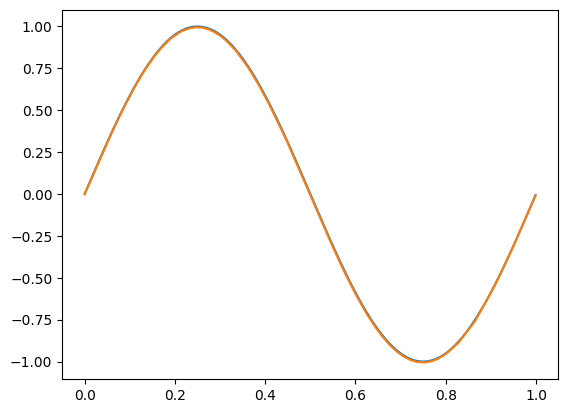

In [10]:
import matplotlib.pyplot as plt
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test,y_test)
plt.plot(X_test,activation3.output)
plt.show()